In [1]:
%matplotlib notebook

In [2]:
# import packages
import numpy as np
import numpy.linalg
import pandas as pd
import scipy.io
import os
import h5py
import matplotlib.pyplot as plt
import cmocean

# set working directory
basepath = '/Volumes/Jokulhaup_5T/Greenland-melange/'

In [ ]:
# !Pip3 install cmocean

In [3]:
# the two equations from the parameters
def EBC_model(c,v):
    c1=float(c[0]); c2=float(c[1]); a=float(c[2]); c3=float(c[3]); c4=float(c[4]) # parse input
    n = ((c1*v**(-a))*np.exp(-v/c2)) + (c3*np.exp(-v/c4)) # generate equation 
    return n
def powerlaw_model(c,v):
    c5=float(c[0]); c6=float(c[1]); # parse input
    n = c5*v**(-c6)
    return n

In [4]:
# normalized error calculation used for automated fitting:
def norm_error(n,nmod,norm_type,normalize_exp):
    res = (np.array(n)-np.array(nmod))/(np.array(n)**normalize_exp) # calculate normalized residuals
    return np.linalg.norm(res,norm_type)

In [5]:
# strip the values from the .mat file structure and return it as a list
def strip_mat_var(vmat):
    var = []
    for v in vmat:
        var.append(v[0])
    return np.array(var)

# 1) Select the file and read in the data


In [6]:
glacier_abbrev = 'ASG' # GLACIER ID
doi = '20150903' # DATE OF SIZE DISTRIBUTION
print('Analyzing size distribution for',glacier_abbrev,'from',doi)

Analyzing size distribution for ASG from 20150903


In [7]:
# grab file and load it
nthresh = 1e-8
for file in os.listdir(basepath+glacier_abbrev+'/DEMs'):
    if doi in file and (file.endswith('melange-DEMfilled.mat')): # or file.endswith('iceberg-data.mat')) and counter < 1:
#     if doi in file and (file.endswith('iceberg-distribution.txt')): # or file.endswith('iceberg-data.mat')) and counter < 1:
        #if file.endswith('iceberg-data.mat'): # if both files exist, specify which one
            matfile = h5py.File(basepath+glacier_abbrev+'/DEMs/'+file,'r')

            v1 = matfile.get('m/melange/Asurfs');
            print(v1)
            v1 = strip_mat_var(v1)
            n1 = matfile.get('m/melange/bergs'); 
            print(n1)
            n1 = strip_mat_var(n1)
            dv1 = matfile.get('m/melange/binwidth'); 
            dv1 = strip_mat_var(dv1)

            # filter
            v1 = v1[n1 > nthresh]
            dv1 = dv1[n1 > nthresh]
            n1 = (n1[n1 > nthresh])/dv1 


<HDF5 dataset "Asurfs": shape (112, 1), type "<f8">
<HDF5 dataset "bergs": shape (112, 1), type "<f4">


In [8]:
# grab parameters file from automated fitting
paramfiles = []
for file in os.listdir(basepath+glacier_abbrev+'/models/'):
    if file.endswith('csv'):
        paramfiles.append(file)
print(str(len(paramfiles))+' parameter files generated.')
paramfile = paramfiles[0] # ADJUST HERE IF THERE ARE MULTIPLE FILES
print(paramfile)

1 parameter files generated.
ASG_parameters_11-Jun-2024_1719.csv


In [9]:
# load parameters from parameter file
params_df = pd.read_csv(basepath+glacier_abbrev+'/models/'+paramfile,
                       names=['date','c1','c2','a','c3','c4','c5','c6'])
subset_df = params_df[params_df.date == int(doi)]
print(subset_df)

# assign the variables
c1=float(subset_df.c1); c2=float(subset_df.c2); a=float(subset_df.a); 
c3=float(subset_df.c3); c4=float(subset_df.c4)
c5=float(subset_df.c5); c6=float(subset_df.c6)

        date            c1            c2  a        c3             c4  c5  c6
28  20150903  3.789306e+07  10097.951373  2  0.000017  149576.893082 NaN NaN


## Plot:

<IPython.core.display.Javascript object>


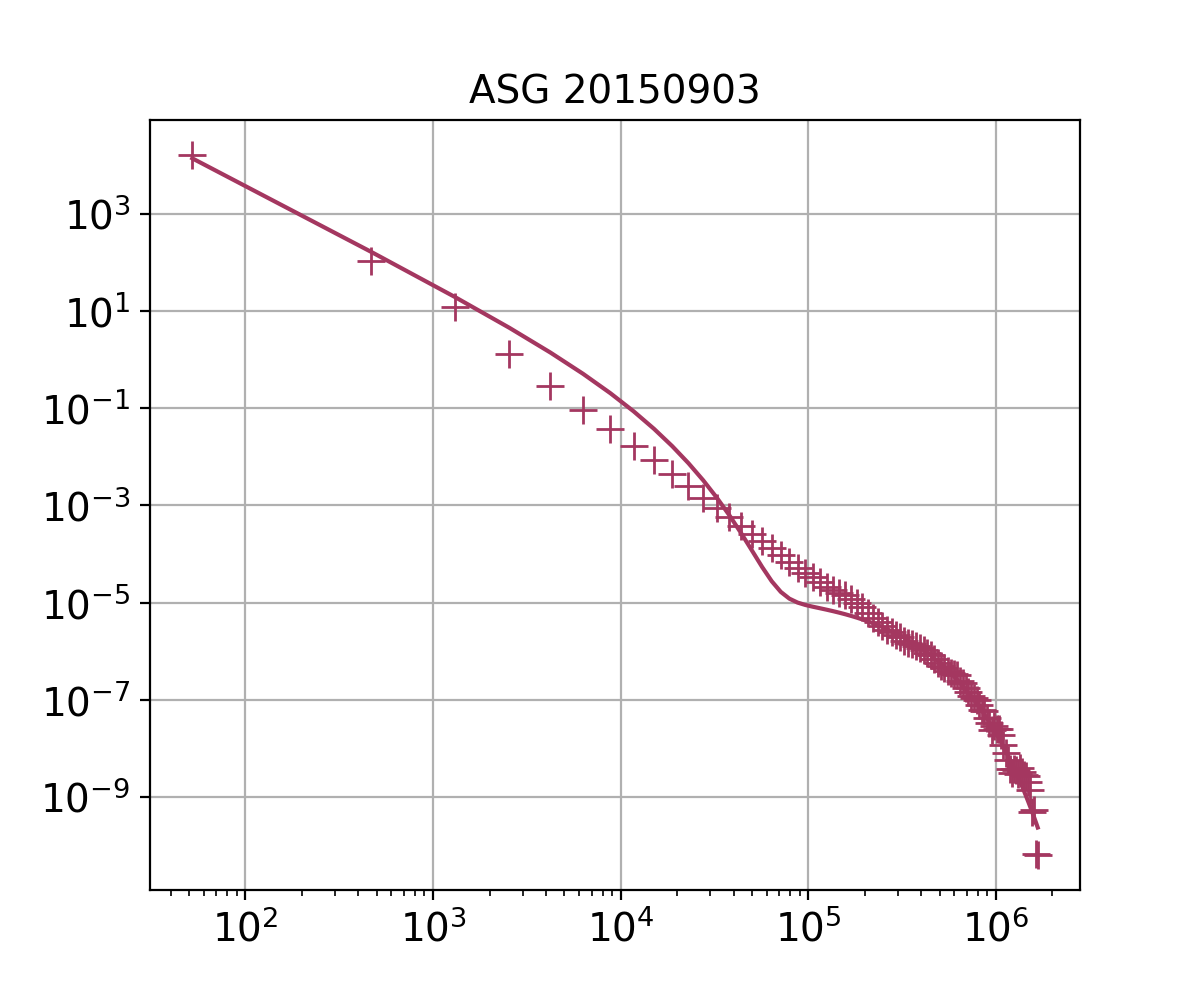

No submarine melt influence.


In [10]:
season_cmap = cmocean.cm.curl(np.linspace(0, 1, 12)) # coloramp
fs=14 # set fontsize

plt.figure(figsize=(6,5))
plt.clf()
plt.loglog(v1,n1,'+', color=season_cmap[int(doi[4:6])], markersize=10) # plot the data
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)

nmod = EBC_model([c1,c2,a,c3,c4],v1) # plot EBC model
plt.loglog(v1,nmod,'-', color=season_cmap[int(doi[4:6])])
plt.title(glacier_abbrev+' '+doi,fontsize=fs)

if not np.isnan(c5) and not np.isnan(c6): # if submarine melt was accounted for
    if c5 > c1:
        print('c5 > c1, no submarine melt influence.')
        c5 = np.NaN; c6 = np.NaN;
    else:
        plt.loglog(v1[0:7], powerlaw_model([c5, c6], v1[0:7]), 'k--') # plot the curve
else:
    print('No submarine melt influence.')   

plt.grid()
plt.show()

In [ ]:
# c5 = np.NaN; c6 = np.NaN; # MANUALLY SET NO SUBMARINE MELT IF THE TAPERING LOOKS INCORRECTLY IDENTIFIED

# 2) Slider GUI to make manual adjustments to fit

In [11]:
from matplotlib.widgets import Slider, Button, RadioButtons

<IPython.core.display.Javascript object>


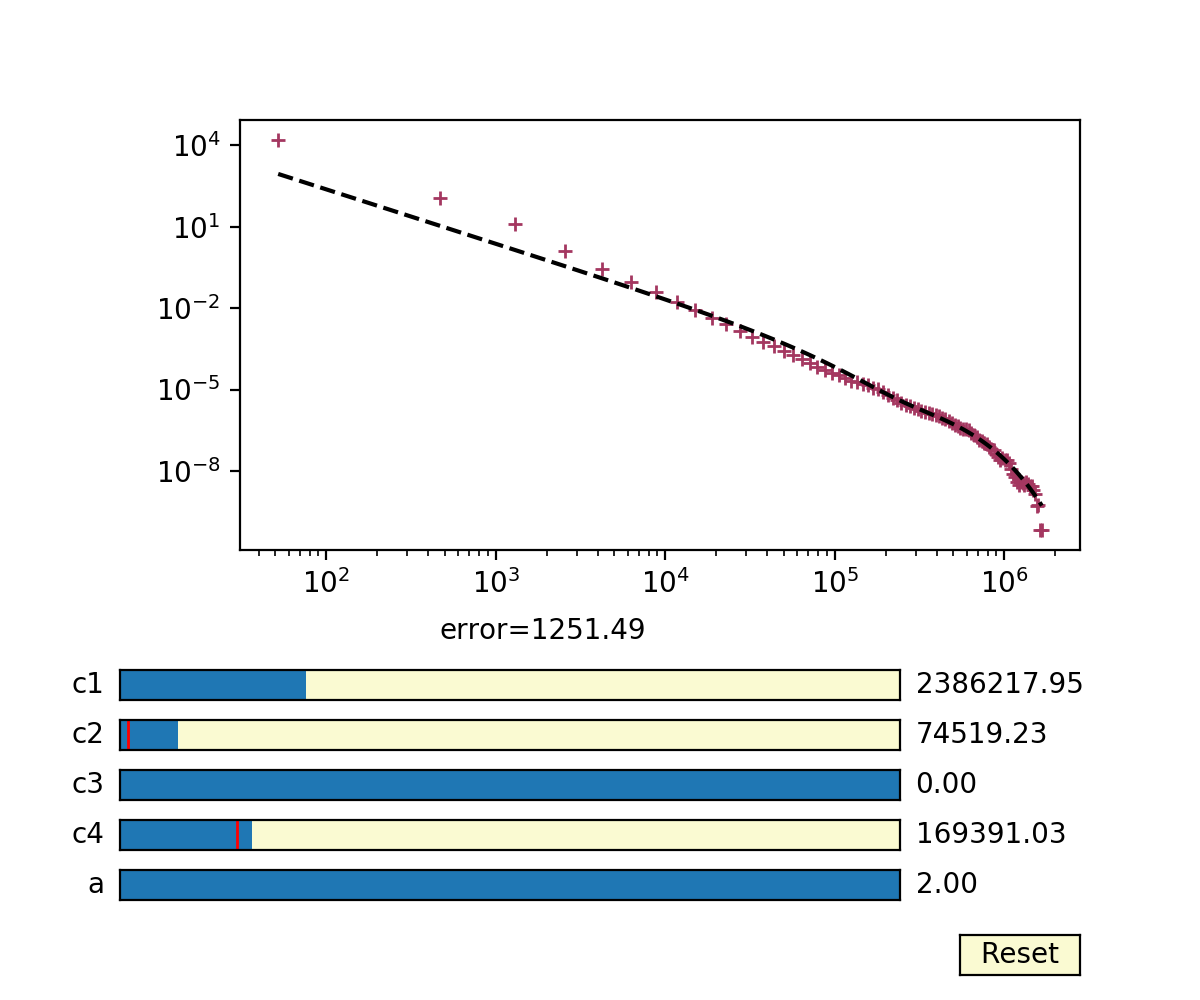

In [12]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111); fig.subplots_adjust(left=0.2, bottom=0.45)

# Draw the initial plot
ax.loglog(v1,n1,'+', color=season_cmap[int(doi[4:6])], markersize=5) # plot the data
# The 'line' variable is used for modifying the line later
[line] = ax.loglog(v1,EBC_model([c1,c2,a,c3,c4],v1),'--', color='k', markersize=10)

# Define an axes area and draw sliders on it:
axis_color = 'lightgoldenrodyellow'
# c1 slider
c1_slider_ax  = fig.add_axes([0.1, 0.3, 0.65, 0.03], facecolor=axis_color)
c1_slider = Slider(c1_slider_ax, 'c1', 0, 1e7, valinit=c1) # adjust range
# c2 slider
c2_slider_ax = fig.add_axes([0.1, 0.25, 0.65, 0.03], facecolor=axis_color)
c2_slider = Slider(c2_slider_ax, 'c2', 0, 1e6, valinit=c2) # adjust range
# c3 slider
c3_slider_ax = fig.add_axes([0.1, 0.2, 0.65, 0.03], facecolor=axis_color)
c3_slider = Slider(c3_slider_ax, 'c3', 0.1e-10, 0.1e-4, valinit=c3) # adjust range
# c4 slider
c4_slider_ax = fig.add_axes([0.1, 0.15, 0.65, 0.03], facecolor=axis_color)
c4_slider = Slider(c4_slider_ax, 'c4', 0, 1e6, valinit=c4) # adjust range
# alpha slider
a_slider_ax = fig.add_axes([0.1, 0.1, 0.65, 0.03], facecolor=axis_color)
a_slider = Slider(a_slider_ax, 'a', 1.67, 2, valinit=a)


error0 = "{:.2f}".format(norm_error(n1,EBC_model([c1,c2,a,c3,c4],v1),2,1.2)) # grab error
t1 = ax.text(v1[round(len(v1)*1e-2)], np.min(n1)*1e-4, # position
              'error='+error0)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    line.set_ydata(EBC_model([c1_slider.val, c2_slider.val,a_slider.val,
                              c3_slider.val,c4_slider.val],v1))
    error = norm_error(n1,EBC_model([c1_slider.val,c2_slider.val,a_slider.val,
                                c3_slider.val,c4_slider.val],v1),2,1.2)
    t1.set_text('error='+"{:.2f}".format(error))
    plt.draw()
    fig.canvas.draw_idle()
c1_slider.on_changed(sliders_on_changed)
c2_slider.on_changed(sliders_on_changed)
c3_slider.on_changed(sliders_on_changed)
c4_slider.on_changed(sliders_on_changed)
a_slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
def reset_button_on_clicked(mouse_event):
    c1_slider.reset()
    c2_slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

plt.show()

## Record final adjusted values

In [13]:
# create folder
if not os.path.exists(basepath+glacier_abbrev+'/manually_adjusted_models/'):
    os.mkdir(basepath+glacier_abbrev+'/manually_adjusted_models/')
    print('directory made')
else:
    print('directory already exists')

directory already exists


In [14]:
# save adjusted figure
plt.savefig(basepath+glacier_abbrev+'/manually_adjusted_models/'
            +glacier_abbrev+'-'+doi+"-model-adjusted.png", dpi=300) 

In [15]:
# save adjusted parameters
c1_new = c1_slider.val; print('c1 = '+str(c1_new))
c2_new = c2_slider.val; print('c2 = '+str(c2_new))
c3_new = c3_slider.val; print('c3 = '+str(c3_new))
c4_new = c4_slider.val; print('c4 = '+str(c4_new))
a_new = a_slider.val; print('a = '+str(a_new))
print('c5 and c6:',c5,c6)
print('Original error = ',error0)

# write to csv
new_df = pd.DataFrame([[c1_new, c2_new, a_new, c3_new, c4_new, str(c5), str(c6)]],
                      columns=['c1','c2','a','c3','c4','c5','c6'])
new_df.to_csv(basepath+glacier_abbrev+'/manually_adjusted_models/'
            +glacier_abbrev+'-'+doi+"-parameters-adjusted.csv") 

c1 = 2386217.9487179485
c2 = 74519.23076923075
c3 = 1e-05
c4 = 169391.02564102566
a = 2
c5 and c6: nan nan
Original error =  492.90
